<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Comparing_AtomVisionSTEM_to_MultisliceSTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Example comparing AtomVision STEM image to multislice simulations

AtomVision is a deep learning package to perform various operations on image data including segmentation and classification of images. In this example, we compare an AtomVision generated STEM image of graphene to images generated from multislice simulations. Simulations can be accelerated through use of GPUs.

## Table of Contents

1. Install AtomVision package
2. Graphene example part 1: generate STEM image using AtomVision convolution approximation
3. Graphene example part 2a: generate STEM image using multislice simulations at various beam dosages using IAM charge densities and Poisson noise.
4. Graphene example part 2b: generate STEM image using multislice simulations at various beam dosages using DFT (GPAW) charge densities and Poisson noise.
5. Calculate FID score for image similarity comparison

## Get AtomVision repository and install

In [1]:
!pip install --pre dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install --pre dglgo -f https://data.dgl.ai/wheels-test/repo.html
!pip install atomvision

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 MB 9.5 MB/s eta 0:00:00
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 53.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=9e9dec7745bb5ea75260

## Install abTEM, GPAW, and related packages

In [2]:
!pip install abtem
!apt install python3-mpi4py cython3 libxc-dev gpaw-data
!pip -q install gpaw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.7/540.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 13.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libxc9
Suggested packages:
  cython-doc python3-numpy
The following NEW packages will be installed:
  cython3 gpaw-data libxc-dev libxc9 python3-mpi4py
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 66.5 MB of archives.
After this operation, 102 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 cython3 amd64 0.29.28-1ubuntu3 [1,336 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 gpaw-data all 0.9.20000-2 [52.7 MB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxc9 amd64 5.1.7-1ubuntu1 [3,900 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxc-dev amd6

In [3]:
pip install Pillow==9.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
atomvision 2023.5.6 requires Pillow>=9.2.0, but you have pillow 9.0.0 which is incompatible.


In [4]:
import os
!pwd
os.chdir('/content')
# Clone ALIGNN repo to get example folder
if not os.path.exists('atomvision'):
  !git clone https://github.com/usnistgov/atomvision.git
os.chdir('atomvision')

/content
Cloning into 'atomvision'...
remote: Enumerating objects: 2008, done.
remote: Counting objects: 100% (2004/2004), done.
remote: Compressing objects: 100% (1646/1646), done.
remote: Total 2008 (delta 369), reused 1942 (delta 338), pack-reused 4
Receiving objects: 100% (2008/2008), 161.66 MiB | 12.87 MiB/s, done.
Resolving deltas: 100% (369/369), done.


Generate AtomVision STEM image for graphene using convolution approximation

In [7]:
!python atomvision/scripts/stem_conv.py --file_path atomvision/tests/POSCAR --output_path Graphene_STEM.png

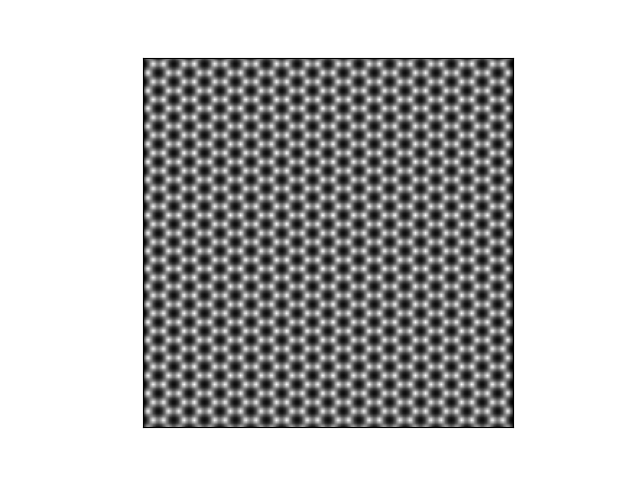

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
Image('Graphene_STEM.png')

Build orthoganlized graphene cell for abTEM simulations using AtomVision POSCAR file for graphene

Cell([4.268108460349401, 2.4641942017968987, 4.000000000000001])


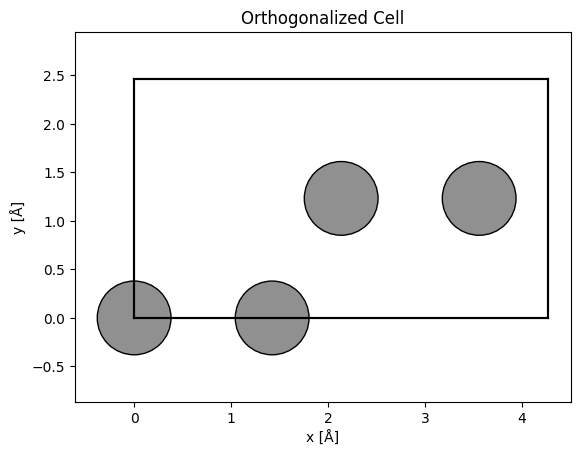

In [9]:
from ase.io import read

from abtem import *
from abtem.structures import orthogonalize_cell

repetitions = (1,1,1)

atoms = read('atomvision/tests/POSCAR')
atoms.rotate(90, 'z', rotate_cell=True)

atoms_orth = orthogonalize_cell(atoms, max_repetitions=2)
atoms_orth *= repetitions

atoms_cell = atoms_orth.cell
atoms_orth.set_cell(atoms_cell)
atoms_orth.center(vacuum=2, axis=2)

fig, ax = plt.subplots()
show_atoms(atoms_orth, ax=ax, title='Orthogonalized Cell')
print(atoms_cell)

Simulate noise-free STEM measurement for graphene via independent atom model (IAM)

Scan:   0%|          | 0/45 [00:00<?, ?it/s]

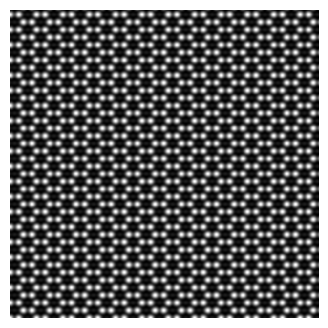

In [10]:
probe = Probe(energy=80e3, semiangle_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=20)
detector = FlexibleAnnularDetector()

potential = Potential(atoms_orth,
                   gpts=256,
                  projection='finite',
                  slice_thickness=1,
                  parametrization='kirkland')
potential = potential.build()
probe.grid.match(potential)



end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

gridscan = GridScan(start=[0, 0], end=end, sampling=probe.ctf.nyquist_sampling * .9)

measurement = probe.scan(gridscan, detector, potential)

haadf_measurement = measurement.integrate(50, 200)

interp_haadf_measurement = haadf_measurement.tile((12,21)).interpolate(.04)

fig, (ax) = plt.subplots(1, 1, figsize=(10,4))

ax.set_xlim([0, 50])
ax.set_ylim([0, 50])
ax.axis('off')

interp_haadf_measurement.show(ax=ax);


plt.savefig('IAM_graphene.png', dpi=256)

Add poisson noise to simulate beam dose effects

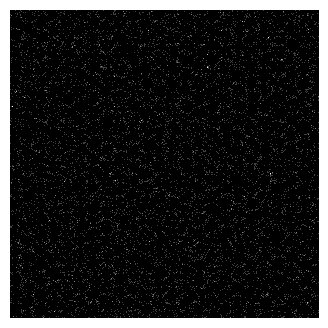

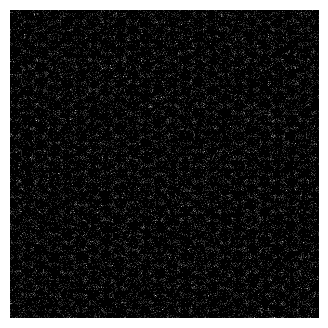

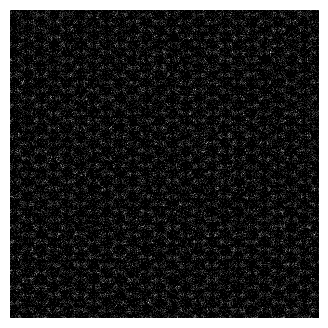

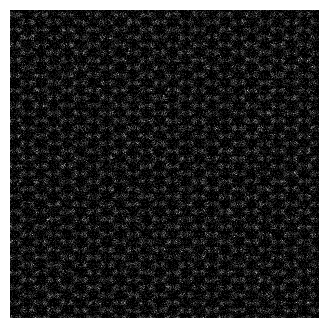

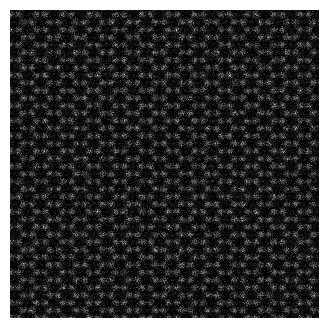

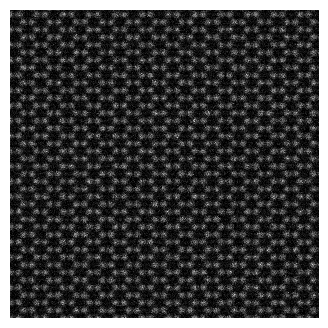

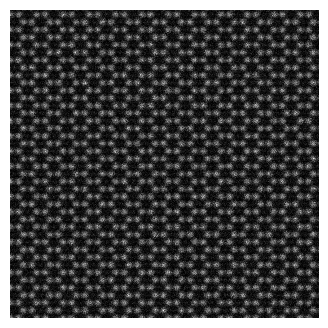

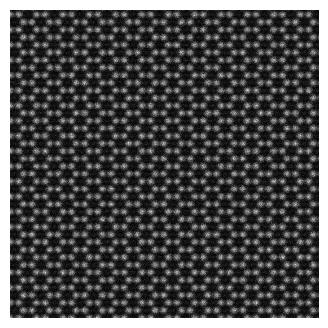

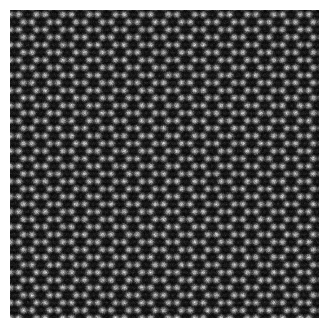

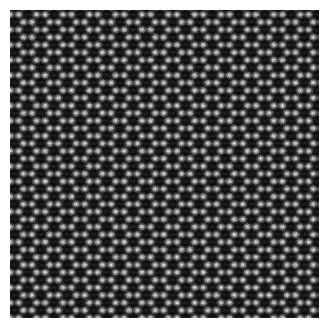

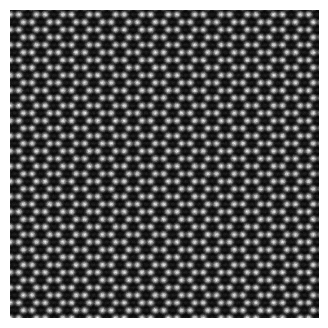

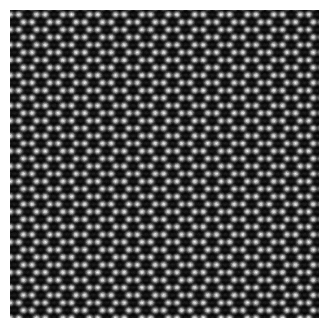

In [11]:
from abtem.noise import poisson_noise

poisson_lst = [1e5, 2.5e5, 5e5, 1e6, 2.5e6, 5e6, 1e7, 2.5e7, 5e7, 1e8, 2.5e8, 5e8]
count = 0
for i in range(len(poisson_lst)):
  noise = poisson_lst[i]
  noise_label = str(noise)
  base_measurement = interp_haadf_measurement
  noisy_measurement = poisson_noise(base_measurement, noise)
  fig, (ax) = plt.subplots(1, 1, figsize=(10,4))
  noisy_measurement.show(ax=ax);
  ax.set_xlim([0, 50])
  ax.set_ylim([0, 50])
  ax.axis('off')
  plt.savefig('IAM_graphene_'+noise_label+'.png', dpi=256)

Simulate noise-free STEM measurement for graphene via GPAW potential

In [12]:
from gpaw import GPAW
from abtem.dft import GPAWPotential

atoms_gpaw = read('atomvision/tests/POSCAR')

repetitions = (1,1,1)

atoms_gpaw.rotate(90, 'z', rotate_cell=True)
atoms_gpaw_orth = orthogonalize_cell(atoms_gpaw, max_repetitions=2)
atoms_gpaw_orth *= repetitions
atoms_gpaw_cell = atoms_gpaw_orth.cell
atoms_gpaw_orth.set_cell(atoms_gpaw_cell)
atoms_gpaw_orth.center(vacuum=2, axis=2)

gpaw = GPAW(h=.1, txt=None, kpts=(3,3,1))
atoms_gpaw_orth.calc = gpaw
atoms_gpaw_orth.get_potential_energy()

-38.98258746681499

In [ ]:
probe = Probe(energy=80e3, semiangle_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=20)
detector = FlexibleAnnularDetector()

dft_pot = GPAWPotential(gpaw, sampling=0.02)
dft_array = dft_pot.build()

dft_potential = dft_array.tile((4,7))



end = (dft_potential.extent[0] / repetitions[0], dft_potential.extent[1] / repetitions[1])

gridscan = GridScan(start=[0, 0], end=end, sampling=probe.ctf.nyquist_sampling * .9)

measurement = probe.scan(gridscan, detector, dft_potential)

haadf_dft_measurement = measurement.integrate(50, 200)

interp_haadf_dft_measurement = haadf_dft_measurement.tile((4,7)).interpolate(.04)

fig, (ax) = plt.subplots(1, 1, figsize=(10,4))

ax.set_xlim([0, 50])
ax.set_ylim([0, 50])
ax.axis('off')

interp_haadf_dft_measurement.show(ax=ax);


plt.savefig('DFT_graphene.png', dpi=256)

Scan:   0%|          | 0/1332 [00:00<?, ?it/s]

Add poisson noise (beam dosage effects) to DFT (GPAW) potential STEM images

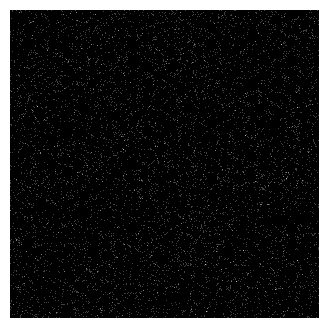

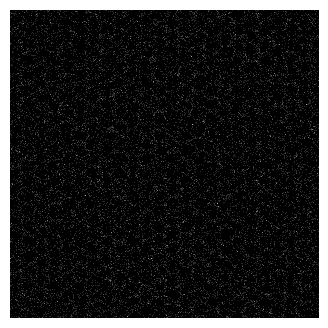

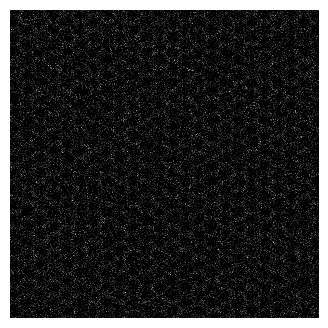

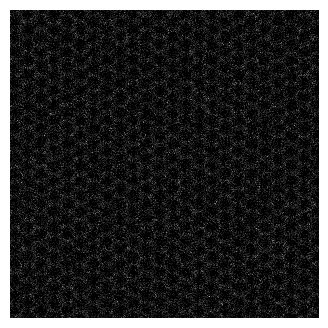

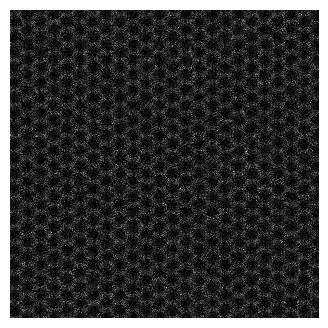

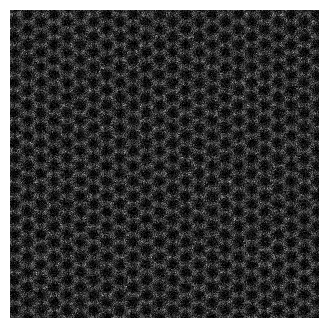

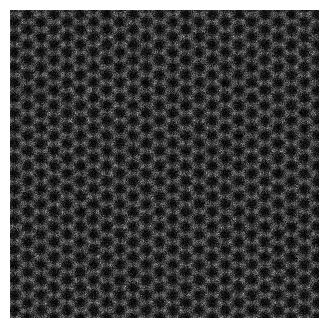

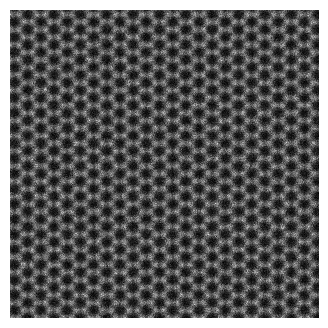

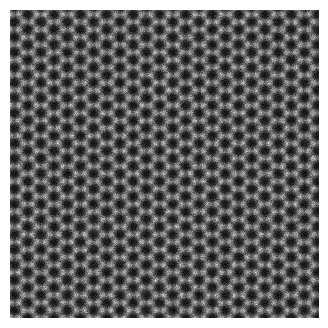

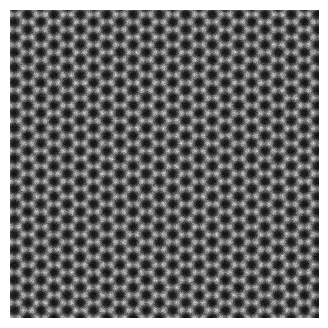

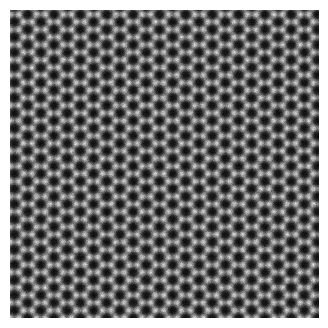

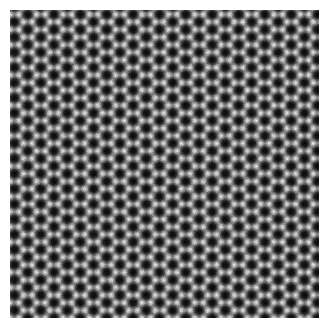

In [ ]:
poisson_lst = [1e5, 2.5e5, 5e5, 1e6, 2.5e6, 5e6, 1e7, 2.5e7, 5e7, 1e8, 2.5e8, 5e8]
count = 0
for i in range(len(poisson_lst)):
  noise = poisson_lst[i]
  noise_label = str(noise)
  base_dft_measurement = interp_haadf_dft_measurement
  noisy_dft_measurement = poisson_noise(base_dft_measurement, noise)
  fig, (ax) = plt.subplots(1, 1, figsize=(10,4))
  noisy_dft_measurement.show(ax=ax);
  ax.set_xlim([0, 50])
  ax.set_ylim([0, 50])
  ax.axis('off')
  plt.savefig('DFT_graphene_'+noise_label+'.png', dpi=256)

Calculate FID Score to Determine Image Similarity

In [ ]:
import os
import numpy as np
from PIL import Image
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
import torchvision.transforms as transforms

#calculate FID score using TORCH inception model
def calculate_fid_score(high_image, low_image, batch_size=32, device='cuda'):
    """
    Calculate the FID score between STEM images generated by different methods.

    Args:
        high_image (torch.Tensor): STEM image generated by a high fidelity (expensive) method.
        low_image (torch.Tensor): STEM image generated by a low fidelity (inexpensive) method.
        batch_size (int): Batch size for processing images.
        device (str): Device to use for calculations ('cuda' or 'cpu').

    Returns:
        float: FID score.
    """
    high_activations = inception_model(high_image.to(device)).detach().cpu().numpy()
    low_activations = inception_model(low_image.to(device)).detach().cpu().numpy()

    mu_high = np.mean(high_activations, axis=0)
    sigma_high = np.atleast_2d(np.cov(high_activations, rowvar=False))

    mu_low = np.mean(low_activations, axis=0)
    sigma_low = np.atleast_2d(np.cov(low_activations, rowvar=False))

    diff = mu_high - mu_low
    cov_mean = sqrtm(sigma_high @ sigma_low)

    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

    fid_score = np.dot(diff, diff) + np.trace(sigma_high) + np.trace(sigma_low) - 2 * np.trace(cov_mean)
    return fid_score

Examples of different FID scores (varied noise levels, GPAW vs. IAM, GPAW vs. Atomvision stem-conv)

In [ ]:
image_dir = "/content/atomvision"

inception_model = inception_v3(pretrained=True, transform_input=False, aux_logits=True)
inception_model = inception_model.eval().to('cuda')

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_paths = [
    ("IAM_graphene_500000000.0.png", "IAM_graphene_250000000.0.png", "FID Score for high (5e8) vs. low (2.5e8) electron dose (e/Angstroms-squared) in IAM:"),
    ("IAM_graphene_500000000.0.png", "IAM_graphene_1000000.0.png", "FID Score for high (5e8) vs. low (1e6) electron dose (e/Angstroms-squared) in IAM:"),
    ("DFT_graphene.png", "IAM_graphene.png", "FID Score for noise-free GPAW vs. IAM:"),
    ("IAM_graphene_2500000.0.png", "Graphene_STEM.png", "FID Score for 2.5e6 e/Angstrom-squard IAM vs. atomvision stem_conv:")
]

for high_image_path, low_image_path, fid_label in image_paths:
    high_image_path = os.path.join(image_dir, high_image_path)
    low_image_path = os.path.join(image_dir, low_image_path)

    high_image = Image.open(high_image_path).convert("RGB")
    low_image = Image.open(low_image_path).convert("RGB")

    high_image = transform(high_image).unsqueeze(0).to('cuda')
    low_image = transform(low_image).unsqueeze(0).to('cuda')

    fid_score = calculate_fid_score(low_image, high_image)
    print(fid_label, fid_score)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 159MB/s] 


FID Score for high (5e8) vs. low (2.5e8) electron dose (e/Angstroms-squared) in IAM: 0.5367433291270833
FID Score for high (5e8) vs. low (1e6) electron dose (e/Angstroms-squared) in IAM: 593.2013988323762
FID Score for noise-free GPAW vs. IAM: 499.20416696001865
FID Score for 2.5e6 e/Angstrom-squard IAM vs. atomvision stem_conv: 444.49547540558206
